In [1]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('../input/textdata/text_train.csv')
df = df.append(pd.read_csv('../input/textdata/text_test.csv'))
display(df.head())

,wav_file,label,transcription
0,Ses03M_impro07_F004,4,no . you didn t get into production . there s ...
1,Ses04M_script03_1_M001,3,i wonder .
2,Ses01M_script03_1_M001,3,i wonder .
3,Ses05M_script02_2_M020,2,what you want me to blow in your ear ?
4,Ses04M_script01_2_F015,0,she goes to sleep in his bed and his memorial ...


In [2]:
col = ['label', 'transcription']
df = df[col]

In [3]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [4]:
df.columns = ['label', 'transcription']

In [5]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

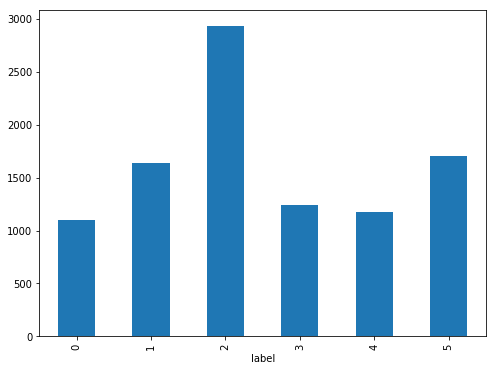

In [6]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(9797, 2464)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [9]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.621
Test Set F-score =  0.606
Test Set Precision =  0.642
Test Set Recall =  0.617
Confusion matrix, without normalization
[[ 78   5  97  21   8  21]
 [  7 168  89  30  12  33]
 [ 29  33 427  43  15  44]
 [  0   0   0 253   0   0]
 [  0   0   0  46 183   0]
 [  9  24 141  19  16 109]]


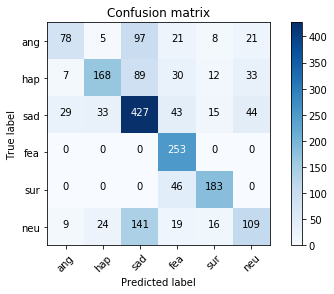

In [10]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.549
Test Set F-score =  0.541
Test Set Precision =  0.712
Test Set Recall =  0.500
Confusion matrix, without normalization
[[ 55   6 158   1   4   6]
 [  4 107 200   3   3  22]
 [ 14  20 516   0   3  38]
 [  0   0  67 186   0   0]
 [  0   5  83   0 141   0]
 [  2   9 231   2   3  71]]


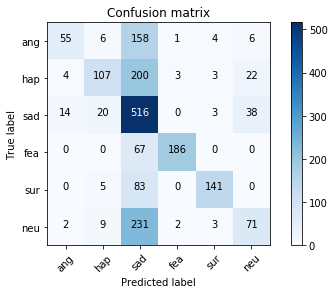

In [11]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('text_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.621
Test Set F-score =  0.630
Test Set Precision =  0.665
Test Set Recall =  0.611
Confusion matrix, without normalization
[[ 91  10  99   1   7  22]
 [  9 204  67   9  10  40]
 [ 41  31 420   8  20  71]
 [  0   0  61 192   0   0]
 [  0   0  43   3 183   0]
 [ 14  37 121   2  16 128]]


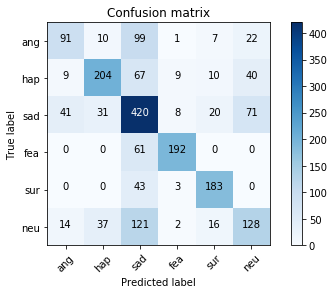

In [12]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('text_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.616
Test Set F-score =  0.615
Test Set Precision =  0.727
Test Set Recall =  0.576
Confusion matrix, without normalization
[[ 79   6 126   1   4  14]
 [  1 177 112  11   7  31]
 [ 19  17 509   8   3  35]
 [  0   0  66 187   0   0]
 [  0   0  74   3 152   0]
 [  3  23 178   4   7 103]]


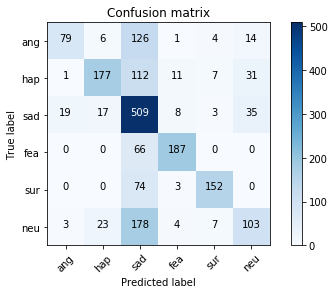

In [13]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('text_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.624
Test Set F-score =  0.619
Test Set Precision =  0.626
Test Set Recall =  0.634
Confusion matrix, without normalization
[[ 89   9  79  20   7  26]
 [  9 196  49  27  13  45]
 [ 46  34 372  40  17  82]
 [  0   0   0 253   0   0]
 [  0   0   0  46 183   0]
 [ 16  33 108  17  14 130]]


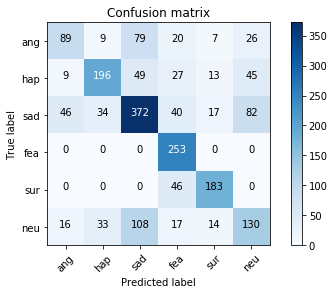

In [14]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('text_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.626
Test Set F-score =  0.629
Test Set Precision =  0.690
Test Set Recall =  0.606
Confusion matrix, without normalization
[[ 87   2 114   1   7  19]
 [  5 188  84  11  10  41]
 [ 28  22 462   9  17  53]
 [  0   0  61 192   0   0]
 [  0   0  43   3 183   0]
 [  5  28 148   4  18 115]]


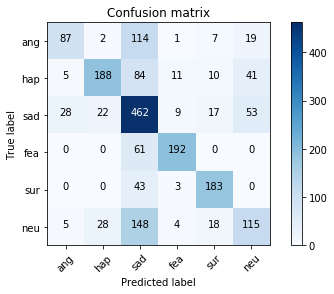

In [15]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('text_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

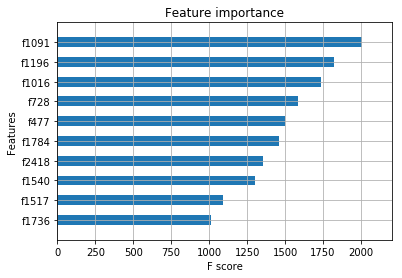

In [16]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)

In [17]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.        , 0.        , 0.00144733, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

Test Set Accuracy =  0.624
Test Set F-score =  0.627
Test Set Precision =  0.685
Test Set Recall =  0.603
Confusion matrix, without normalization
[[ 84   6 115   1   7  17]
 [  6 185  86   8  13  41]
 [ 31  22 461   7  15  55]
 [  0   0  61 192   0   0]
 [  0   0  43   3 183   0]
 [ 11  26 146   3  14 118]]


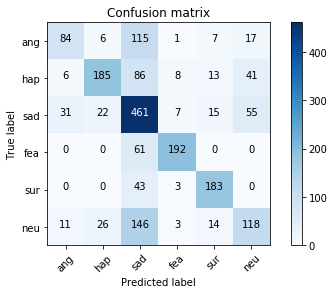

In [18]:
# Load predicted probabilities
with open('text_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('text_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('text_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('text_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('text_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('text_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0


# Show metrics
display_results(y_test, ensemble_pred_probs)